In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

%matplotlib inline
plt.style.use(['grayscale'])

prefixo_dados = '201807151414'

In [2]:
import numpy as np
import pandas as pd

class Transformacao():
    def __init__(self):
        self.finalidades = np.array(['aluguel', 'venda'], dtype=object)
        self.tipos = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])

    def transformar(self, X):
        X_novo = self._selecionar_atributos(X)
        
        finalidades_codificadas = self._codificar_finalidades(X_novo)
        tipos_codificados = self._codificar_tipos(X_novo)
       
        X_novo = self._unir_atributos(X_novo, [
            finalidades_codificadas,
            tipos_codificados,
        ])            
        
        X_novo = self._remover_atributos(X_novo)
        
        return X_novo
    
    def _selecionar_atributos(self, X):
        colunas = [
            'tipo_id',
            'finalidade',
            'preco',
            'area',
            'quartos',
            'suites',
            'banheiros',
            'vagas',
            'latitude',
            'longitude',
            'area_privativa',
        ]

        return X[colunas].copy()
     
    def _unir_atributos(self, X, atributos):
        return X.join(atributos)
    
    def _remover_atributos(self, X):
        return X.drop(['finalidade', 'finalidade_aluguel', 'tipo_id'], axis=1)
    
    def _codificar_finalidades(self, X):
        finalidades_prefixo = 'finalidade_'
        finalidades_codificadas = pd.get_dummies(X['finalidade'],
                                                 prefix=finalidades_prefixo,
                                                 prefix_sep='')
        finalidades_codificadas = finalidades_codificadas \
            .T.reindex(finalidades_prefixo + self.finalidades).T.fillna(0)
        return finalidades_codificadas
    
    def _codificar_tipos(self, X):
        tipos_prefixo = 'tipo_id_'
        tipos_colunas = [tipos_prefixo + str(x) for x in self.tipos]
        tipos_codificados = pd.get_dummies(X['tipo_id'],
                                           prefix=tipos_prefixo, prefix_sep='')
        tipos_codificados = tipos_codificados.T.reindex(tipos_colunas) \
            .T.fillna(0)
        return tipos_codificados

In [3]:
eventos = pd.read_csv('dados/{}-eventos.csv'.format(prefixo_dados),
                      error_bad_lines=False, warn_bad_lines=False,
                      low_memory=False, index_col=False)
print('{} eventos carregados'.format(eventos.shape[0]))

eventos.head(1)

2579770 eventos carregados


id  tipo_id finalidade  area  quartos  suites  banheiros  vagas  \
0  4159        1      venda    85        3       1          2      2   

    latitude  longitude  area_privativa     preco  contato  
0 -19.870854 -43.929058               0  520000.0        0

In [4]:
from sklearn.model_selection import train_test_split

X = eventos.drop(['contato'], axis=1)
y = eventos['contato']

X_treino, X_teste, y_treino, y_teste = \
    train_test_split(X, y,test_size=0.2, random_state=1, stratify=y)

In [5]:
transformacao = Transformacao()
X_treino_transformado = transformacao.transformar(X_treino)
X_teste_transformado = transformacao.transformar(X_teste)

In [6]:
import xgboost as xgb

dtreino = xgb.DMatrix(X_treino_transformado, y_treino)
dteste = xgb.DMatrix(X_teste_transformado, y_teste)

In [7]:
atributos_monotonicos = [0] * X_treino_transformado.shape[1]
atributos_monotonicos[X_treino_transformado.columns.get_loc('preco')] = -1
atributos_monotonicos[X_treino_transformado.columns.get_loc('area')] = 1
atributos_monotonicos[X_treino_transformado.columns.get_loc('vagas')] = 1

restricoes_monotonicas = '(' + ','.join([str(m) for m in atributos_monotonicos]) + ')'

In [8]:
parametros = {
    'objective': 'binary:logistic',
    'eta': 0.1,
    'max_depth': 5,
    'nthread': 4,
    'eval_metric': 'logloss',
    'monotone_constraints': restricoes_monotonicas,
}

%time modelo = xgb.train(parametros, dtreino, num_boost_round=5000, \
                         evals=[(dteste,'teste')], verbose_eval=100, \
                         early_stopping_rounds=100)

[0]	teste-logloss:0.600901
Will train until teste-logloss hasn't improved in 100 rounds.
[100]	teste-logloss:0.041277
[200]	teste-logloss:0.040919
[300]	teste-logloss:0.040755
[400]	teste-logloss:0.040651
[500]	teste-logloss:0.040598
[600]	teste-logloss:0.040548
[700]	teste-logloss:0.040526
[800]	teste-logloss:0.040514
[900]	teste-logloss:0.040507
Stopping. Best iteration:
[860]	teste-logloss:0.040502

CPU times: user 1h 56min 10s, sys: 27 s, total: 1h 56min 37s
Wall time: 43min 4s


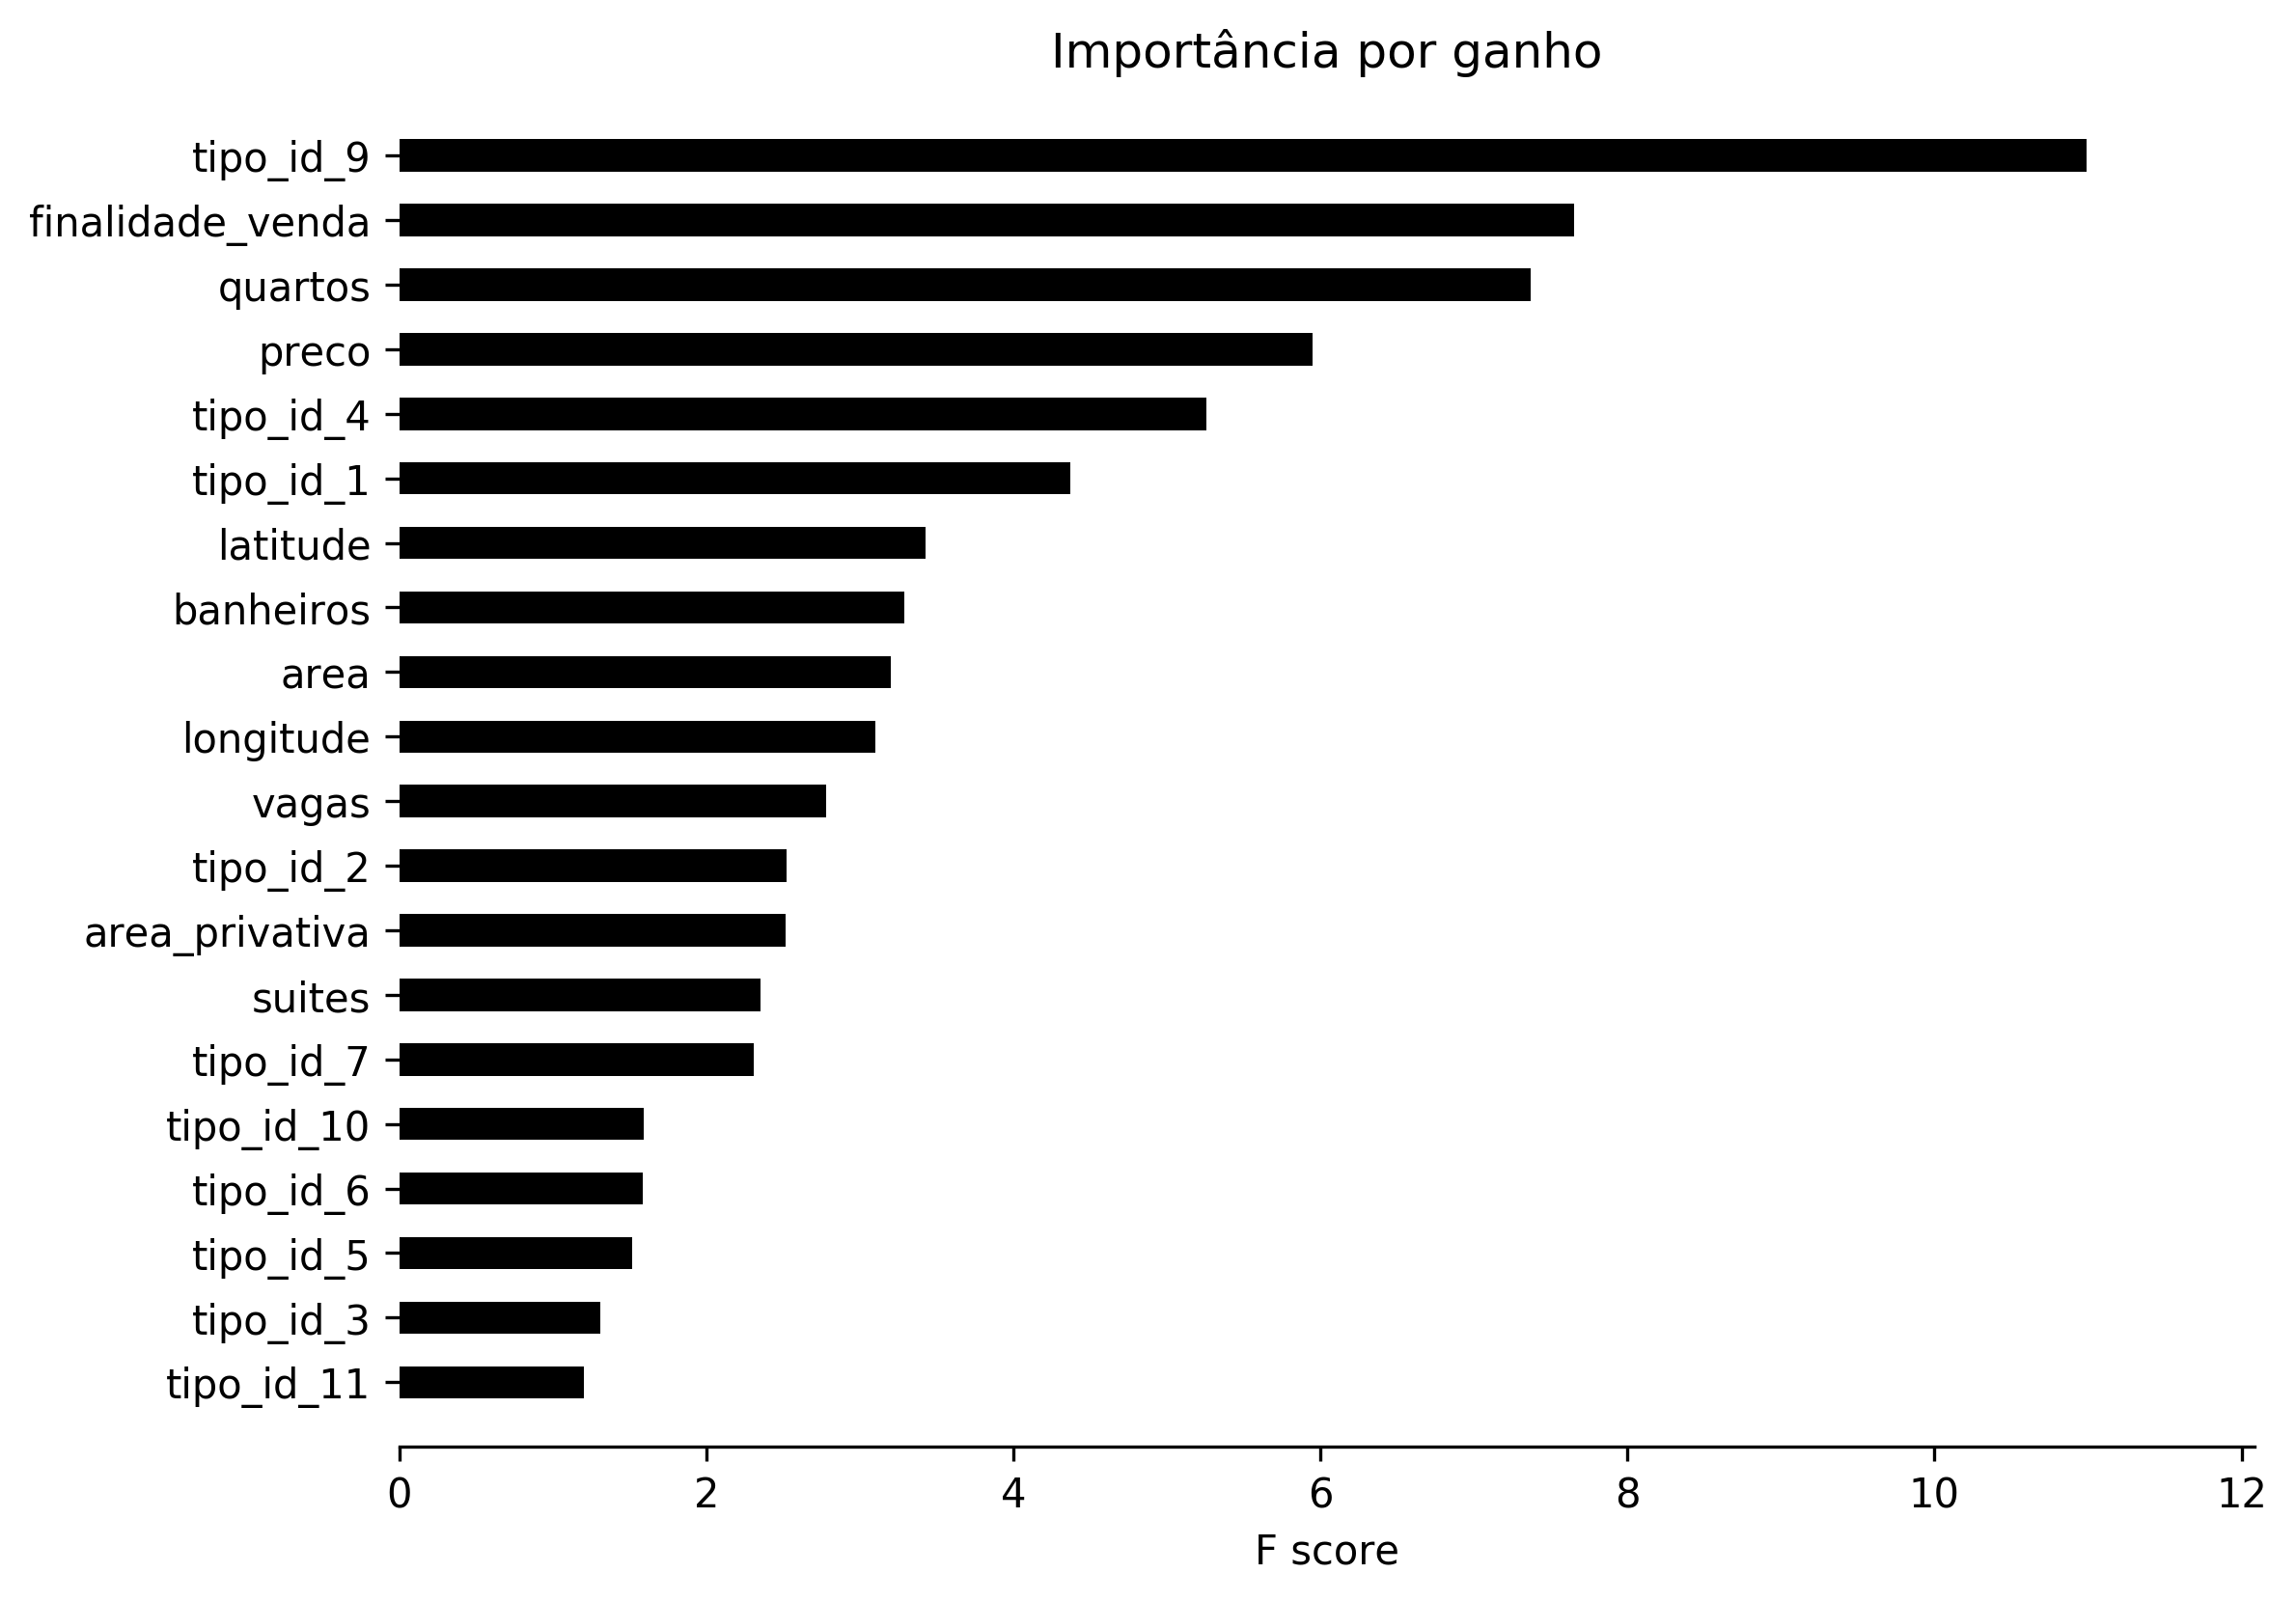

In [9]:
fig1, ax1 = plt.subplots(figsize=(8.27, 6.2025), dpi=300)
xgb.plot_importance(modelo, importance_type='gain',
                    show_values=False, ax=ax1, ylabel='',
                    title='Importância por ganho', height=0.5)
ax1.grid(False)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['left'].set_visible(False)
plt.savefig('latex/dados/figuras/atributos-importancia-ganho')

plt.show()

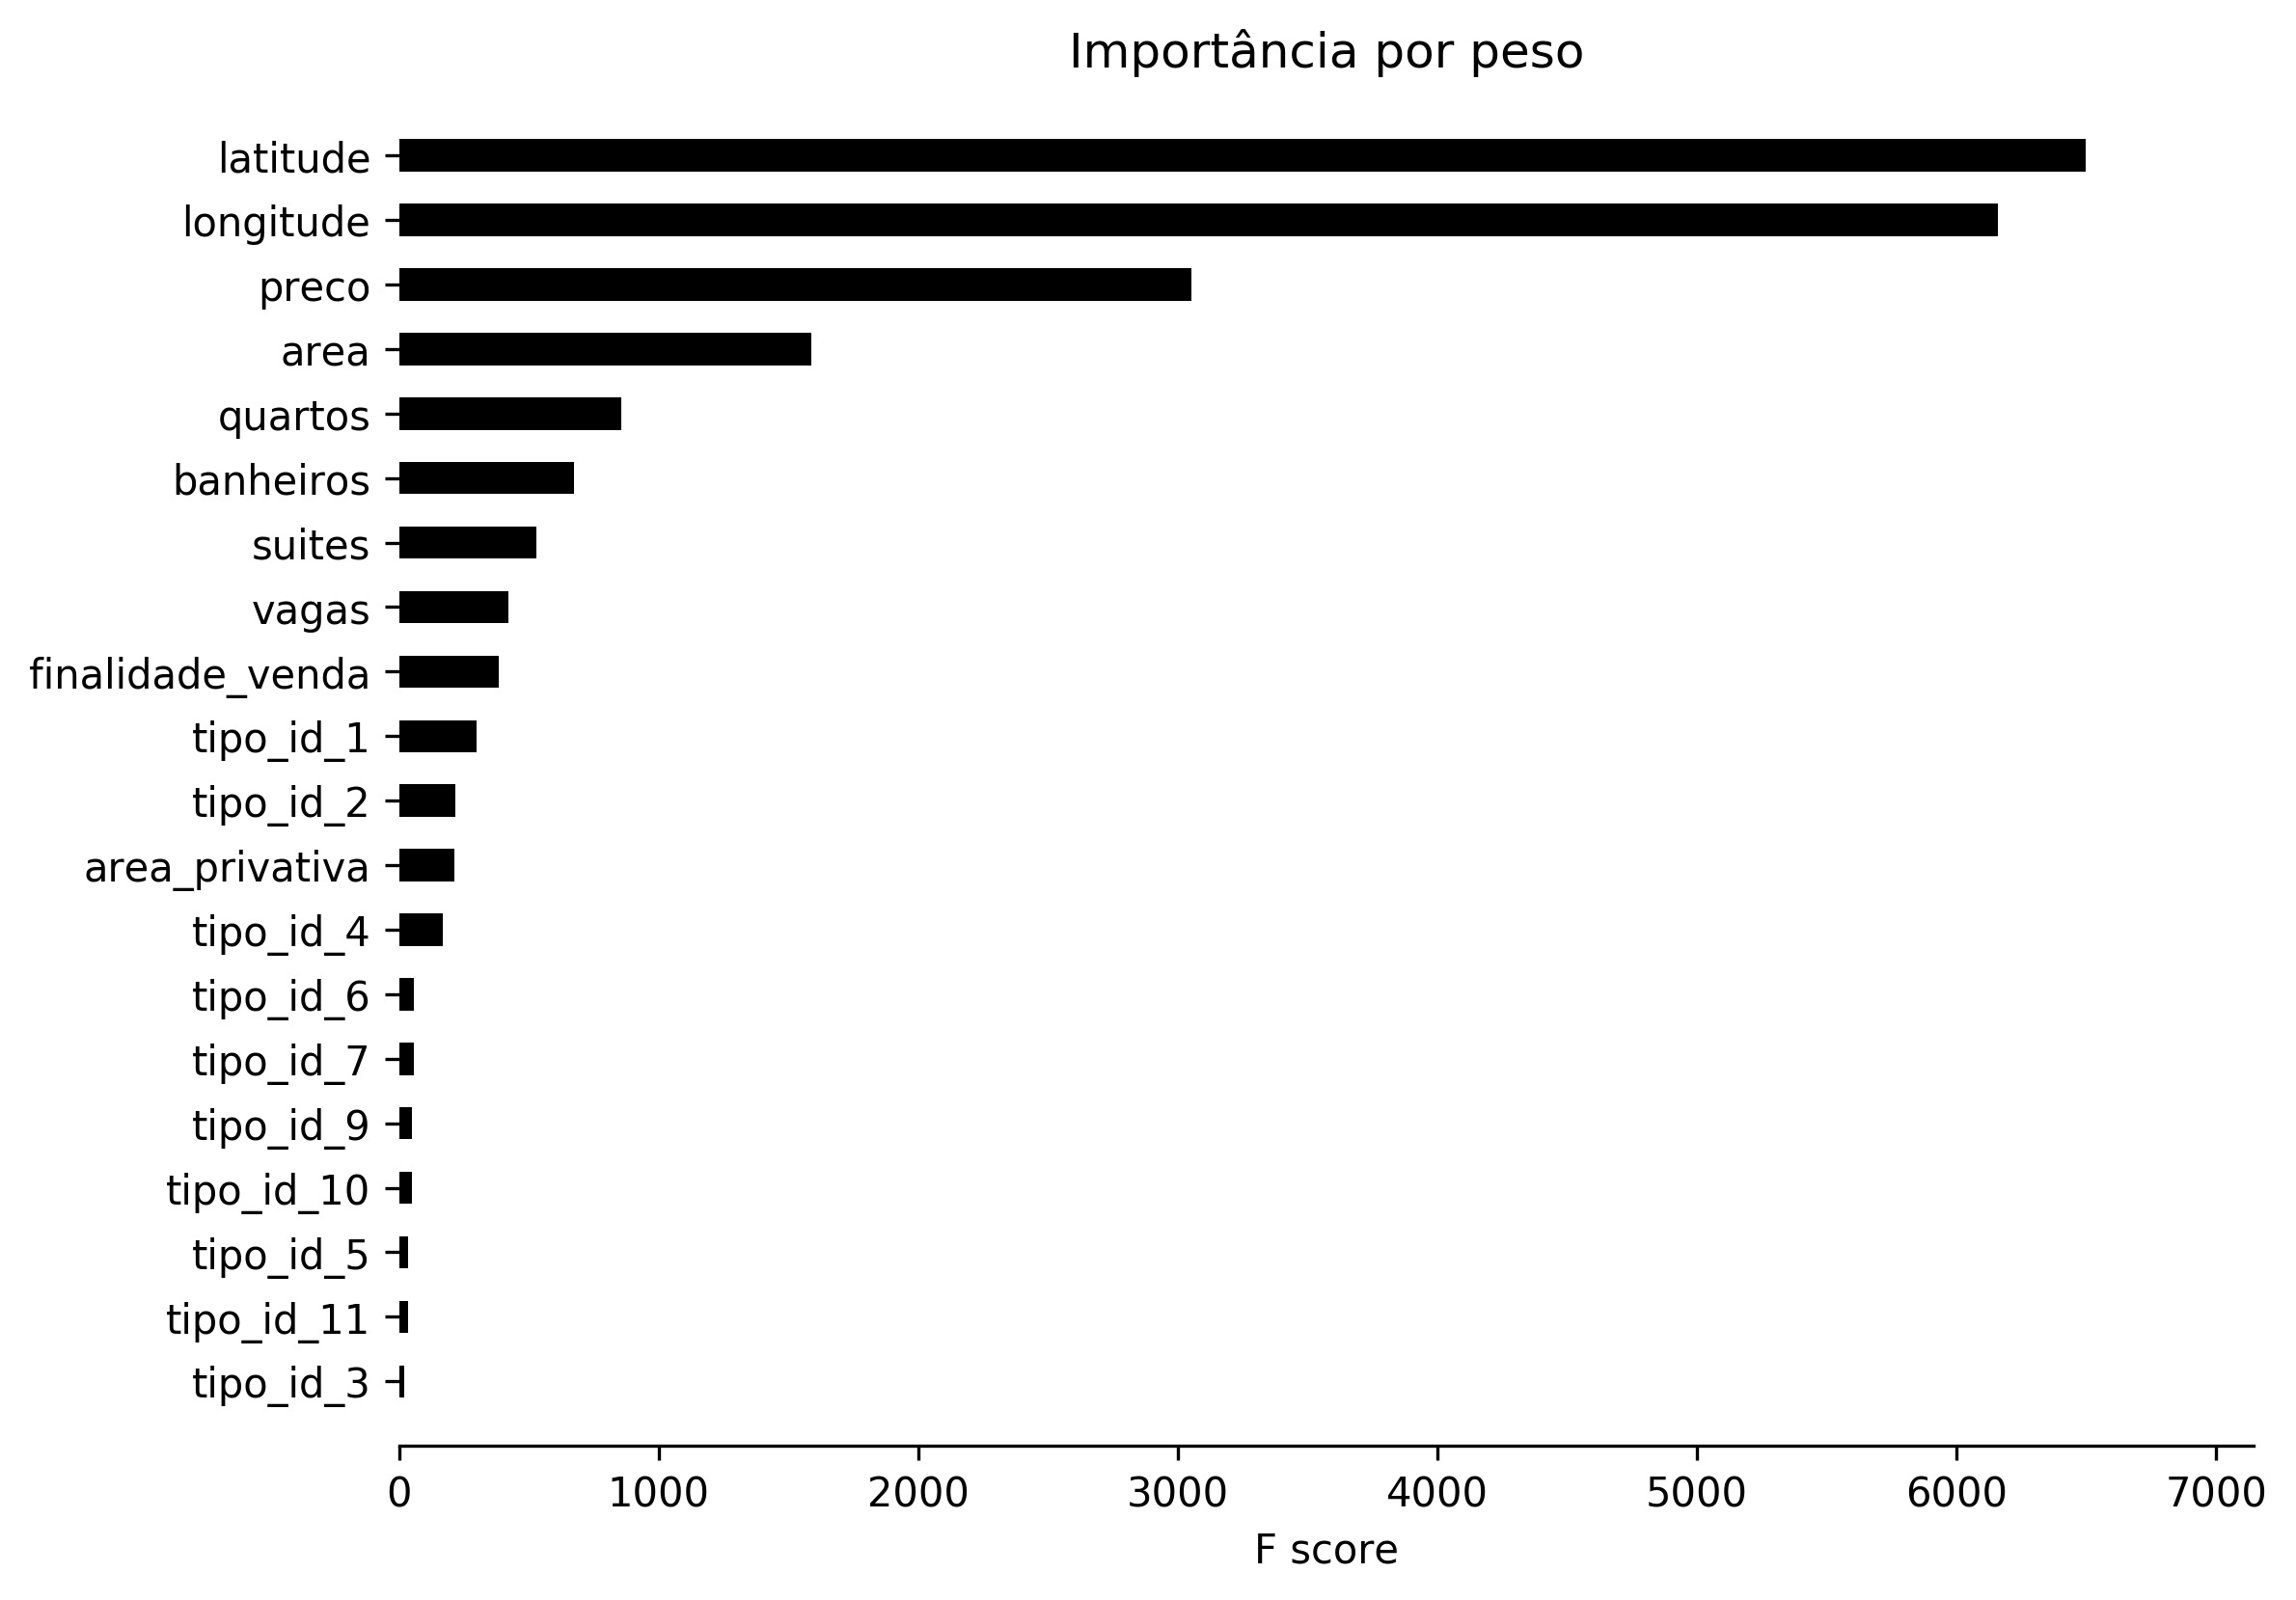

In [10]:
fig2, ax2 = plt.subplots(figsize=(8.27, 6.2025), dpi=300)
xgb.plot_importance(modelo, importance_type='weight',
                    show_values=False, ax=ax2, ylabel='',
                    title='Importância por peso', height=0.5)
ax2.grid(False)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)
plt.savefig('latex/dados/figuras/atributos-importancia-peso')

plt.show()